In [1]:
%load_ext autoreload
%autoreload 2

import cartopy.crs as ccrs
import funs as fu
import geopandas
import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import regression_funs as rfu
import xarray as xr
from sklearn.linear_model import ElasticNetCV


# constants

In [39]:
# PATH_TO_FILE = '../data_in/flexpart-mosaic-data_alias/AIRTRACER_100m.nc'

# PATH_TO_SO2 = '../data_in/flexpart-mosaic-data_alias/MSAQSO2L4_2005-2018_v01-04_20190314.h5'

# PATH_TO_ST = '../data_in/ciapitof_masked_filtered.csv'

# PATH_TO_BC = '../data_in/black_carbon_channel6_masked_5min.csv'
# PATH_TO_BC = '../data_in/black_carbon_channel6_raw_5min.csv'


PATH_TO_ST = "../data_in/ciapitof_raw_filtered.csv"

PATH_200_CLUS = "../data_out/cluster1000.nc"

OUT_FILE = "../data_out2/20_clus_MSA_sources_inverse_raw.csv"
OUT_DS_FILE = "../data_out2/DS_20__MSA_sources_inverse_raw.nc"
OUT_CONTRS_FILE = "../data_out2/CONTRS_20__MSA_sources_inverse_raw.csv"

OUT_MEAS_FILE = "../data_out2/MEAS_20__MSA_sources_inverse_raw.csv"


LA = "lat"
LO = "lon"
AT = "AIRTRACER"
L = "lab"

SA = "sa"
MSA = "msa"
IA = "ia"

BC = "bc_masked_ngm3"
# BC = 'bc_raw_ngm3'

LBC = "log(bc)"

LSA = "log10(sa)"
LMSA = "log10(msa)"
LIA = "log10(ia)"

DATA_OUT = "../data_out"

In [3]:
PAR = MSA
#

# open and plot PAR timeseries

In [4]:
def _get_df():
    df = pd.read_csv(PATH_TO_ST, index_col=0, parse_dates=True)
    zeros = df[MSA] > 0
    print("zeros vs non zeros")
    print(zeros.value_counts())
    df = df[zeros]
    return df


df = _get_df()

zeros vs non zeros
True     92400
False     1656
Name: msa, dtype: int64


In [5]:
df = df["2020-03":]

In [6]:
df[PAR].quantile([0, 0.999])

0.000    1.034413e+03
0.999    5.783121e+07
Name: msa, dtype: float64

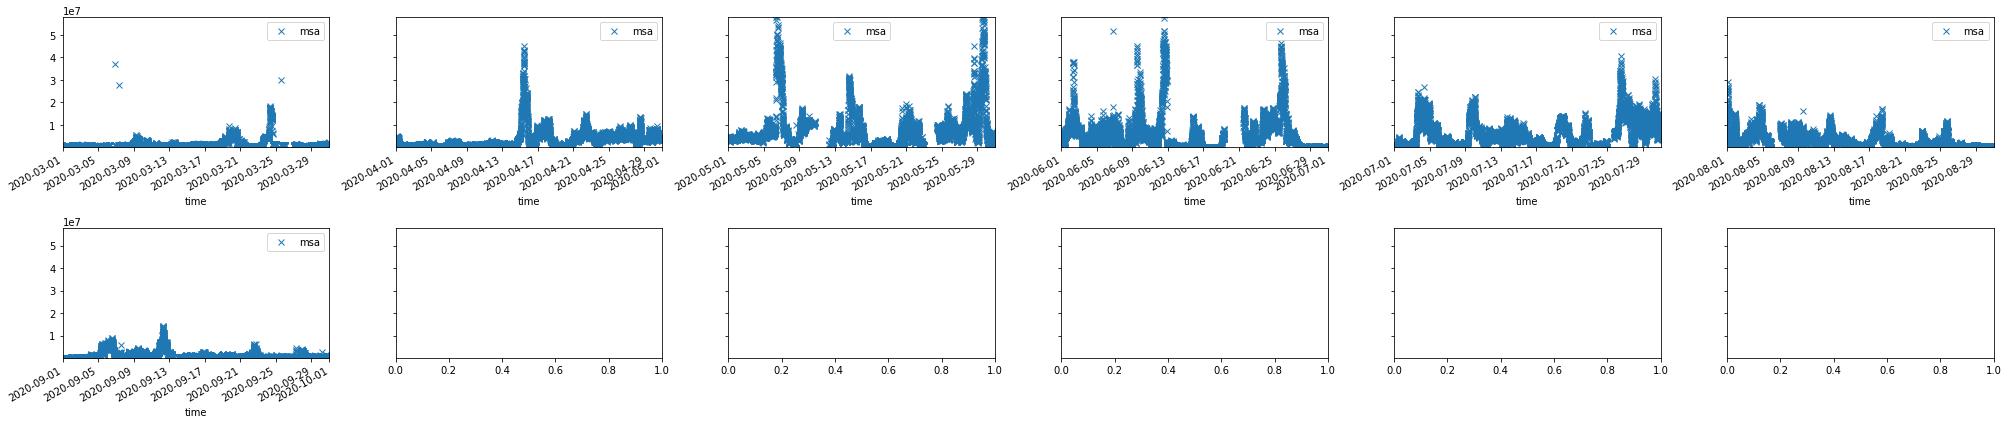

In [7]:
def plt_1(df, ax=None):
    if ax is None:
        f, ax = plt.subplots(figsize=(10, 5))
    df[[PAR]].plot(ax=ax, marker="x", lw=0)


def mplt(df):
    qm, qM = df[PAR].quantile([0, 0.999])
    f, axs = plt.subplots(2, 6, sharey=True, figsize=(28, 6))
    axf = axs.flatten()
    mm = df.index.min()
    mM = df.index.max()

    ms = [m.strftime("%Y-%m") for m in pd.date_range(mm, mM, freq="M")]
    for i, m in enumerate(ms):
        plt_1(df.loc[m], ax=axf[i])
        ax = axf[i]
        m_ = pd.to_datetime(m) + pd.Timedelta(30, "D")
        #         print(m_)
        ax.set_xlim(pd.to_datetime(m), m_)
        ax.set_ylim(qm, qM)
    #         ax.set_yscale('symlog',linthresh=1e5,linscale=.1)
    #         ax.set_yticks([0,*[a*10**5 for a in range(1,10)],1e5,1e6,1e7])
    f.tight_layout()


mplt(df)

(0.0, 104129145.4793396)

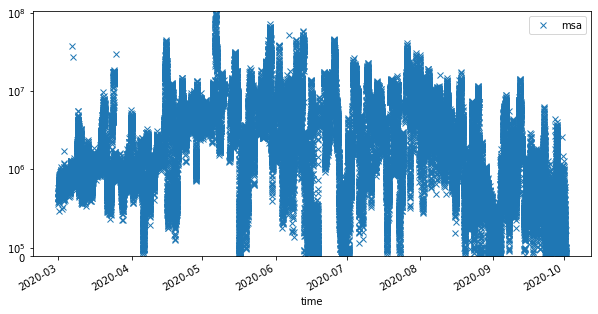

In [8]:
plt_1(df)
plt.gca().set_yscale("symlog", linthresh=1e5, linscale=0.1)
plt.gca().set_ylim(0, None)

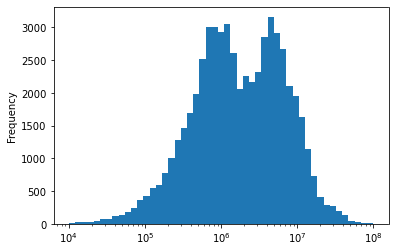

In [9]:
def _plt_dist(df):
    df[PAR].plot.hist(bins=np.geomspace(1e4, 1e8))
    plt.gca().set_xscale("log")


_plt_dist(df)

# open and merge flex 200 ro 1000 clusters

In [10]:
ds = xr.open_dataset(PATH_200_CLUS)

In [11]:
def _merge_ds_and_df(ds, df):
    dsf = ds.groupby(L).sum().to_dataframe()[AT].unstack(L)

    df1 = df

    df2 = df1.resample("3H").median()

    dm = pd.merge(
        df2, dsf, left_index=True, right_index=True, how="inner", validate="1:1"
    )
    return dm, dsf


dm, dsf = _merge_ds_and_df(ds, df)

# 1st CV Inverse modeling elastic NET

66.10819898266031 0.9999


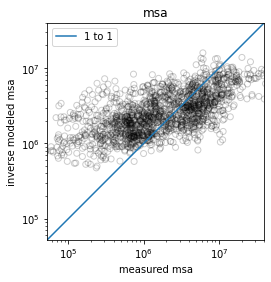

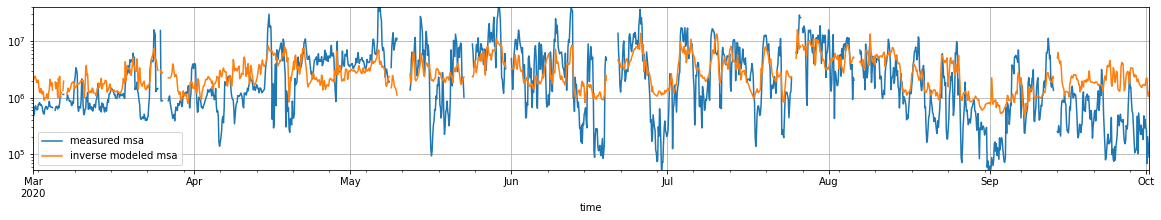

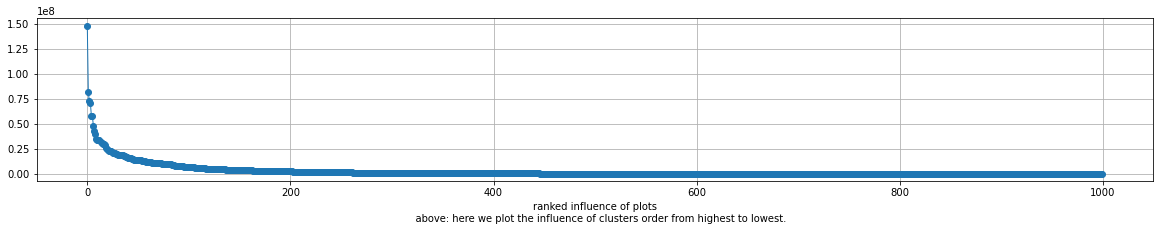

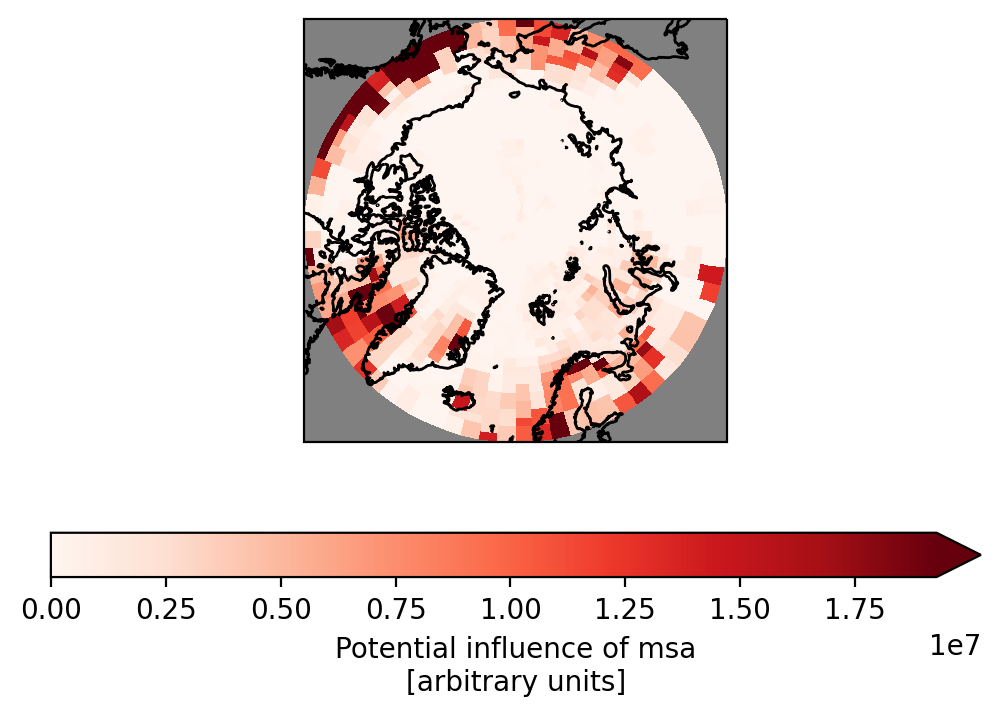

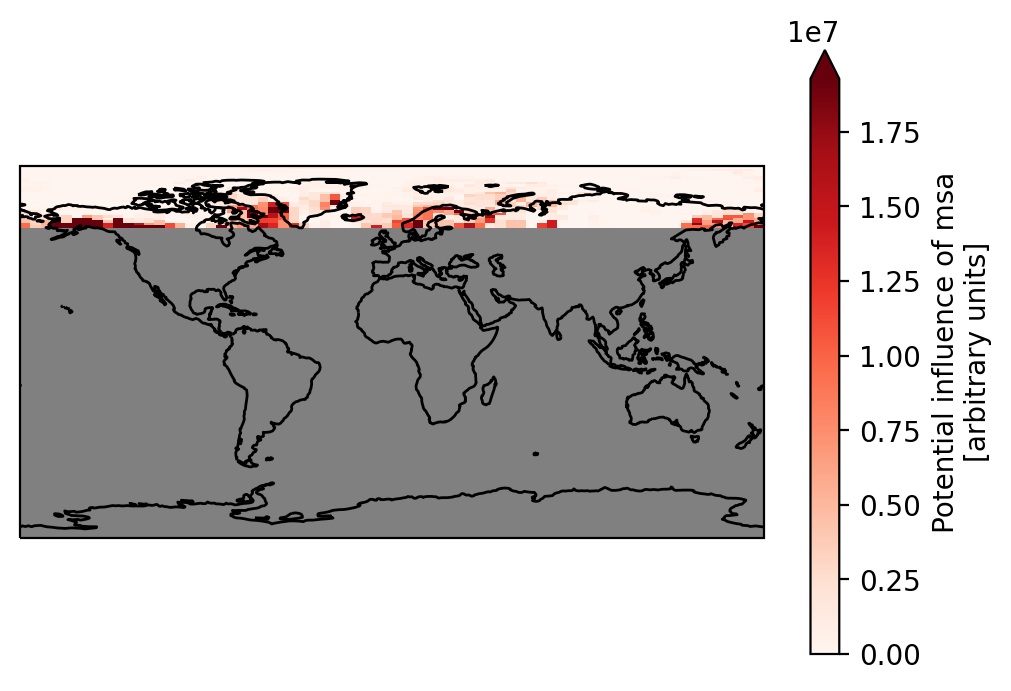

In [12]:
# for PAR in [SA,MSA,IA]:
def plt_el_net(dsf, dm):
    pred, cdf, y, yn, dp, regr = rfu.elastic_net_reg2(dsf, dm, PAR)
    MEA = f"measured {PAR}"
    MOD = f"inverse modeled {PAR}"
    rfu.scatter_plot(y, yn, pred, MEA, MOD, PAR)
    rfu.mea_vs_mod_plot(y, yn, dp, pred, MEA, MOD)
    rfu.rank_cluster_inf(cdf)
    dd2 = rfu.get_plot_inf(cdf, L, ds, PAR)
    rfu.plot_map(dd2)
    rfu.plot_map_rect(dd2)
    return regr


regr = plt_el_net(dsf, dm)

In [51]:
??rfu.elastic_net_reg2

Signature: rfu.elastic_net_reg2(dsf, dm, PAR, l1=None)
Docstring: <no docstring>
Source:   
def elastic_net_reg2(dsf, dm, PAR, l1 = None):
    from sklearn.linear_model import ElasticNetCV

    c200 = dsf.columns

    X = dm[c200]

    ### normalize X
    xn = np.sqrt(  (X ** 2).sum()  ) ** (1/1)
    XX = X.divide(xn, axis=1)
    #############


    _y = dm[PAR]
    yn = _y.notna()
    y = _y[yn]
    
    if l1 is None:
        ii = [.1, .5, .7, .9, .95,
          .999, .9999, .99999, .999999, .9999999, 1]
    else:
        ii = l1
        
    regr = ElasticNetCV(
        cv=5, random_state=0, positive=True, l1_ratio=ii, fit_intercept=False)

    regr.fit(XX[yn], y[yn])

    print(regr.alpha_,regr.l1_ratio_)

    pred = regr.predict(XX[yn])
    dp = pd.Series(pred, index=y[yn].index)
    _cdf = pd.Series(regr.coef_, index=XX.columns)
    cdf = _cdf / xn
    return pred, cdf, y, yn, dp, regr
File:      ~/Documents/Work_DA/Py-packs/flexpart-mosaic/nbV2/regression_funs.py
Type:      func

In [52]:
pred, cdf, y, yn, dp, regr = rfu.elastic_net_reg2(dsf, dm, PAR)

66.10819898266031 0.9999


In [14]:
def get_rat(dp, y, yn):
    from sklearn.linear_model import LinearRegression

    lr = LinearRegression(fit_intercept=True).fit(dp[yn].to_frame(), y[yn])

    r2 = lr.score(dp[yn].to_frame(), y[yn])
    coef = lr.coef_.item()
    inte = lr.intercept_

    return r2, coef, inte


r2, rat, inte = get_rat(dp, y, yn)
rat, r2, inte

(1.5012069940567017, 0.3228064676714102, -808076.0)

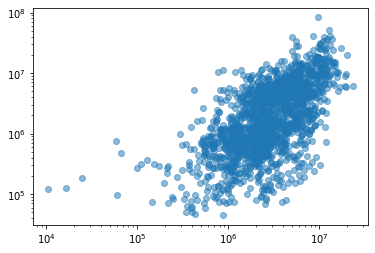

In [15]:
plt.scatter(dp[yn] * rat + inte, y[yn], alpha=0.5)
plt.gca().set_yscale("log")
plt.gca().set_xscale("log")

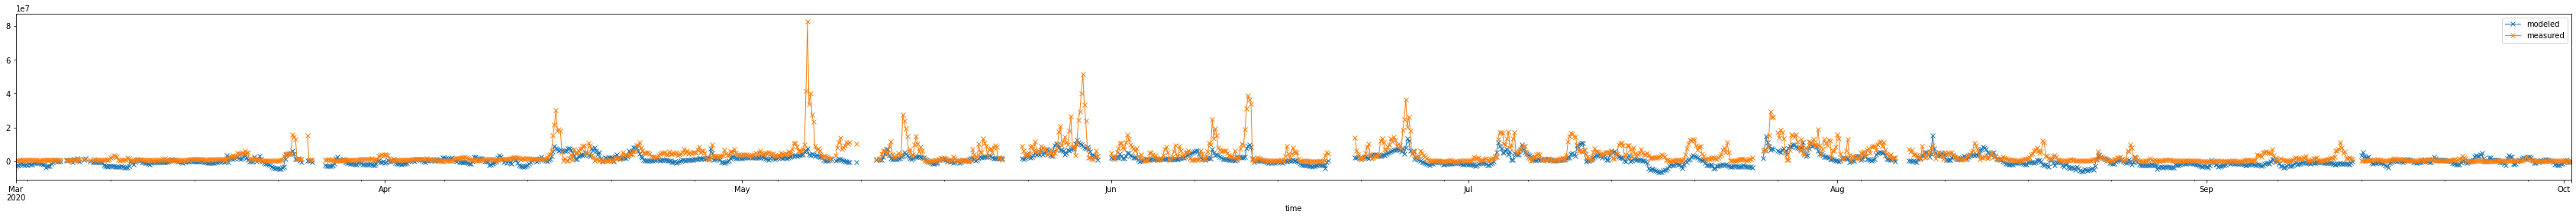

In [16]:
def _plot(rat, dm, dsf, cdf, y, inte):
    # AA = rat #should be 1
    _ = dm[dsf.columns] * (cdf * rat + inte)
    __ = _.sum(axis=1)[yn].resample("3H").mean()
    __.plot(lw=1, marker="x", label="modeled")
    plt.gcf().set_figwidth(60)
    #     plt.gca().set_yscale('symlog',linthresh=1e5,linscale=.1)
    #     plt.gca().set_ylim(0,None)
    y[yn].resample("3H").mean().plot(lw=1, marker="x", label="measured")
    plt.gca().legend()


_plot(rat, dm, dsf, cdf, y, inte)

In [17]:
def get_contr(rat, dm, dsf, cdf, A, yn, inte):
    _cdf = cdf > 0
    #     AA = rat #should be 1
    _ = (dm[dsf.columns] * (cdf * rat + inte))[yn].T.where(_cdf).T
    __ = _.sum(axis=0)
    a = __.sort_values()[::-1].cumsum() / __.sum()
    __ = __.where(a < A, 0)
    return __


contr = get_contr(rat, dm, dsf, cdf, 1, yn, inte)

In [18]:
contr

0             0.0
1             0.0
2             0.0
3             0.0
4             0.0
          ...    
995    20583538.0
996           0.0
997           0.0
998           0.0
999           0.0
Length: 1000, dtype: float32

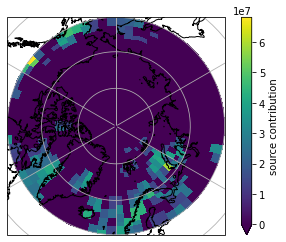

In [19]:
def _plt(ds, contr, ax=None):
    import matplotlib as mpl

    # pred, cdf, y, yn, dp, regr = rfu.elastic_net_reg2(dsf, dm, PAR)

    _1 = ds["lab"].to_dataframe()["lab"].iloc[:, 1].replace(contr.to_dict()).to_xarray()
    _1.name = "source contribution"

    if ax is None:
        _, ax = plt.subplots(subplot_kw=dict(projection=ccrs.Orthographic(0, 90)))
    ax.coastlines()
    ax.gridlines()
    _1.plot(ax=ax, transform=ccrs.PlateCarree(), vmin=0)


_plt(ds, contr)

In [20]:
N = 13


def _clus(dm, dsf, cdf, contr, ds, yn, rat, inte, N):
    #     N = 20

    from sklearn.cluster import KMeans

    contrs_ = (dm[dsf.columns] * (cdf * rat + inte)).T.where(contr > 0, 0).T[yn]

    _norm = np.sqrt((contrs_**2).sum())

    _nn = contrs_ / _norm
    _nn1 = _nn.dropna(axis=1)

    km = KMeans(N, random_state=123)

    _l = km.fit_predict(_nn1.T.values) + 1

    _l1 = pd.Series(_l, index=_nn1.T.index)
    _nl = _norm * 0 + _l1

    def _reorder_by_inf(_nl, contrs_):
        i_ = (
            contrs_.T.groupby(_nl)
            .sum()
            .T.sum()
            .sort_values()[::-1]
            .reset_index()["index"]
        )
        i_.index = i_.index + 1
        _order = {v: i for i, v in i_.items()}
        _nl = _nl.replace(_order)
        return _nl

    _nl = _reorder_by_inf(_nl, contrs_)

    d_ = ds["lab"].to_series().replace(_nl.to_dict()).to_xarray()
    d_.name = "sorted_inf_clusters"
    return d_, contrs_, _nl


(ds["sorted_inf_clusters"], contrs, nl) = _clus(
    dm, dsf, cdf, contr, ds, yn, rat, inte, N
)

In [21]:
a = regr.alpha_
l = regr.l1_ratio_

In [22]:
a, l

(66.10819898266031, 0.9999)

In [23]:
def _plot_clust_infs(contrs, nl, dsf, cdf, y, rat, dm, inte, yn, N):
    AA = 1
    clus_ts = contrs.T.groupby(nl).sum().T[yn].resample("3H").mean()
    for i in range(1, N + 1):
        (AA * clus_ts[i]).plot(c=plt.get_cmap("tab20")(i - 1), lw=5)
    plt.gcf().set_figwidth(60)
    plt.gca().legend()
    # plt.gca().set_yscale('symlog')

    # (contrs.T.groupby(nl).sum().sum()*rat).plot(c='.7', ls='--', marker='D')

    def plt_model(dm):
        _ = dm[dsf.columns] * (cdf * rat + inte)
        __ = _.sum(axis=1)
        __[yn].resample("3H").mean().plot(
            lw=1, marker="+", label="modeled", alpha=0.5, c="k"
        )

    plt_model(dm)

    y[yn].resample("3H").mean().plot(
        lw=1, marker="o", label="measured", c="k", mfc="none", alpha=0.5
    )

    plt.legend()
    ymin, ymax = y[yn].quantile([0, 0.999])


#     plt.gca().set_ylim(ymin,ymax)

/var/folders/xl/wx70j1c50bsdzdy63_wpbhrxpglmw2/T/ipykernel_47445/2105437306.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  clus_ts = contrs.T.groupby(nl).sum().T[yn].resample('3H').mean()


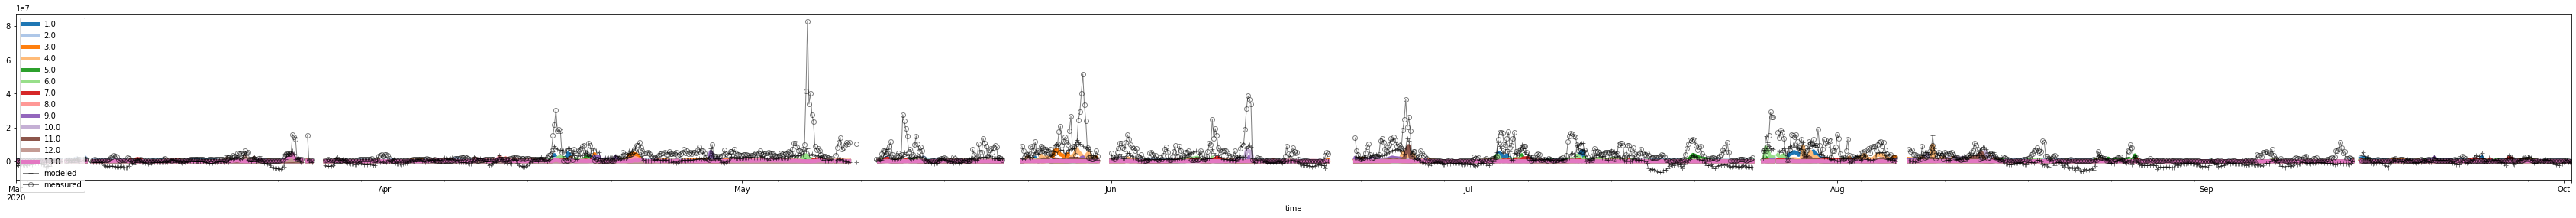

In [24]:
_plot_clust_infs(contrs, nl, dsf, cdf, y, rat, dm, inte, yn, N)

/var/folders/xl/wx70j1c50bsdzdy63_wpbhrxpglmw2/T/ipykernel_47445/1956761208.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  clus_ts = contrs.T.groupby(nl).sum().T[yn].resample('3H').mean()


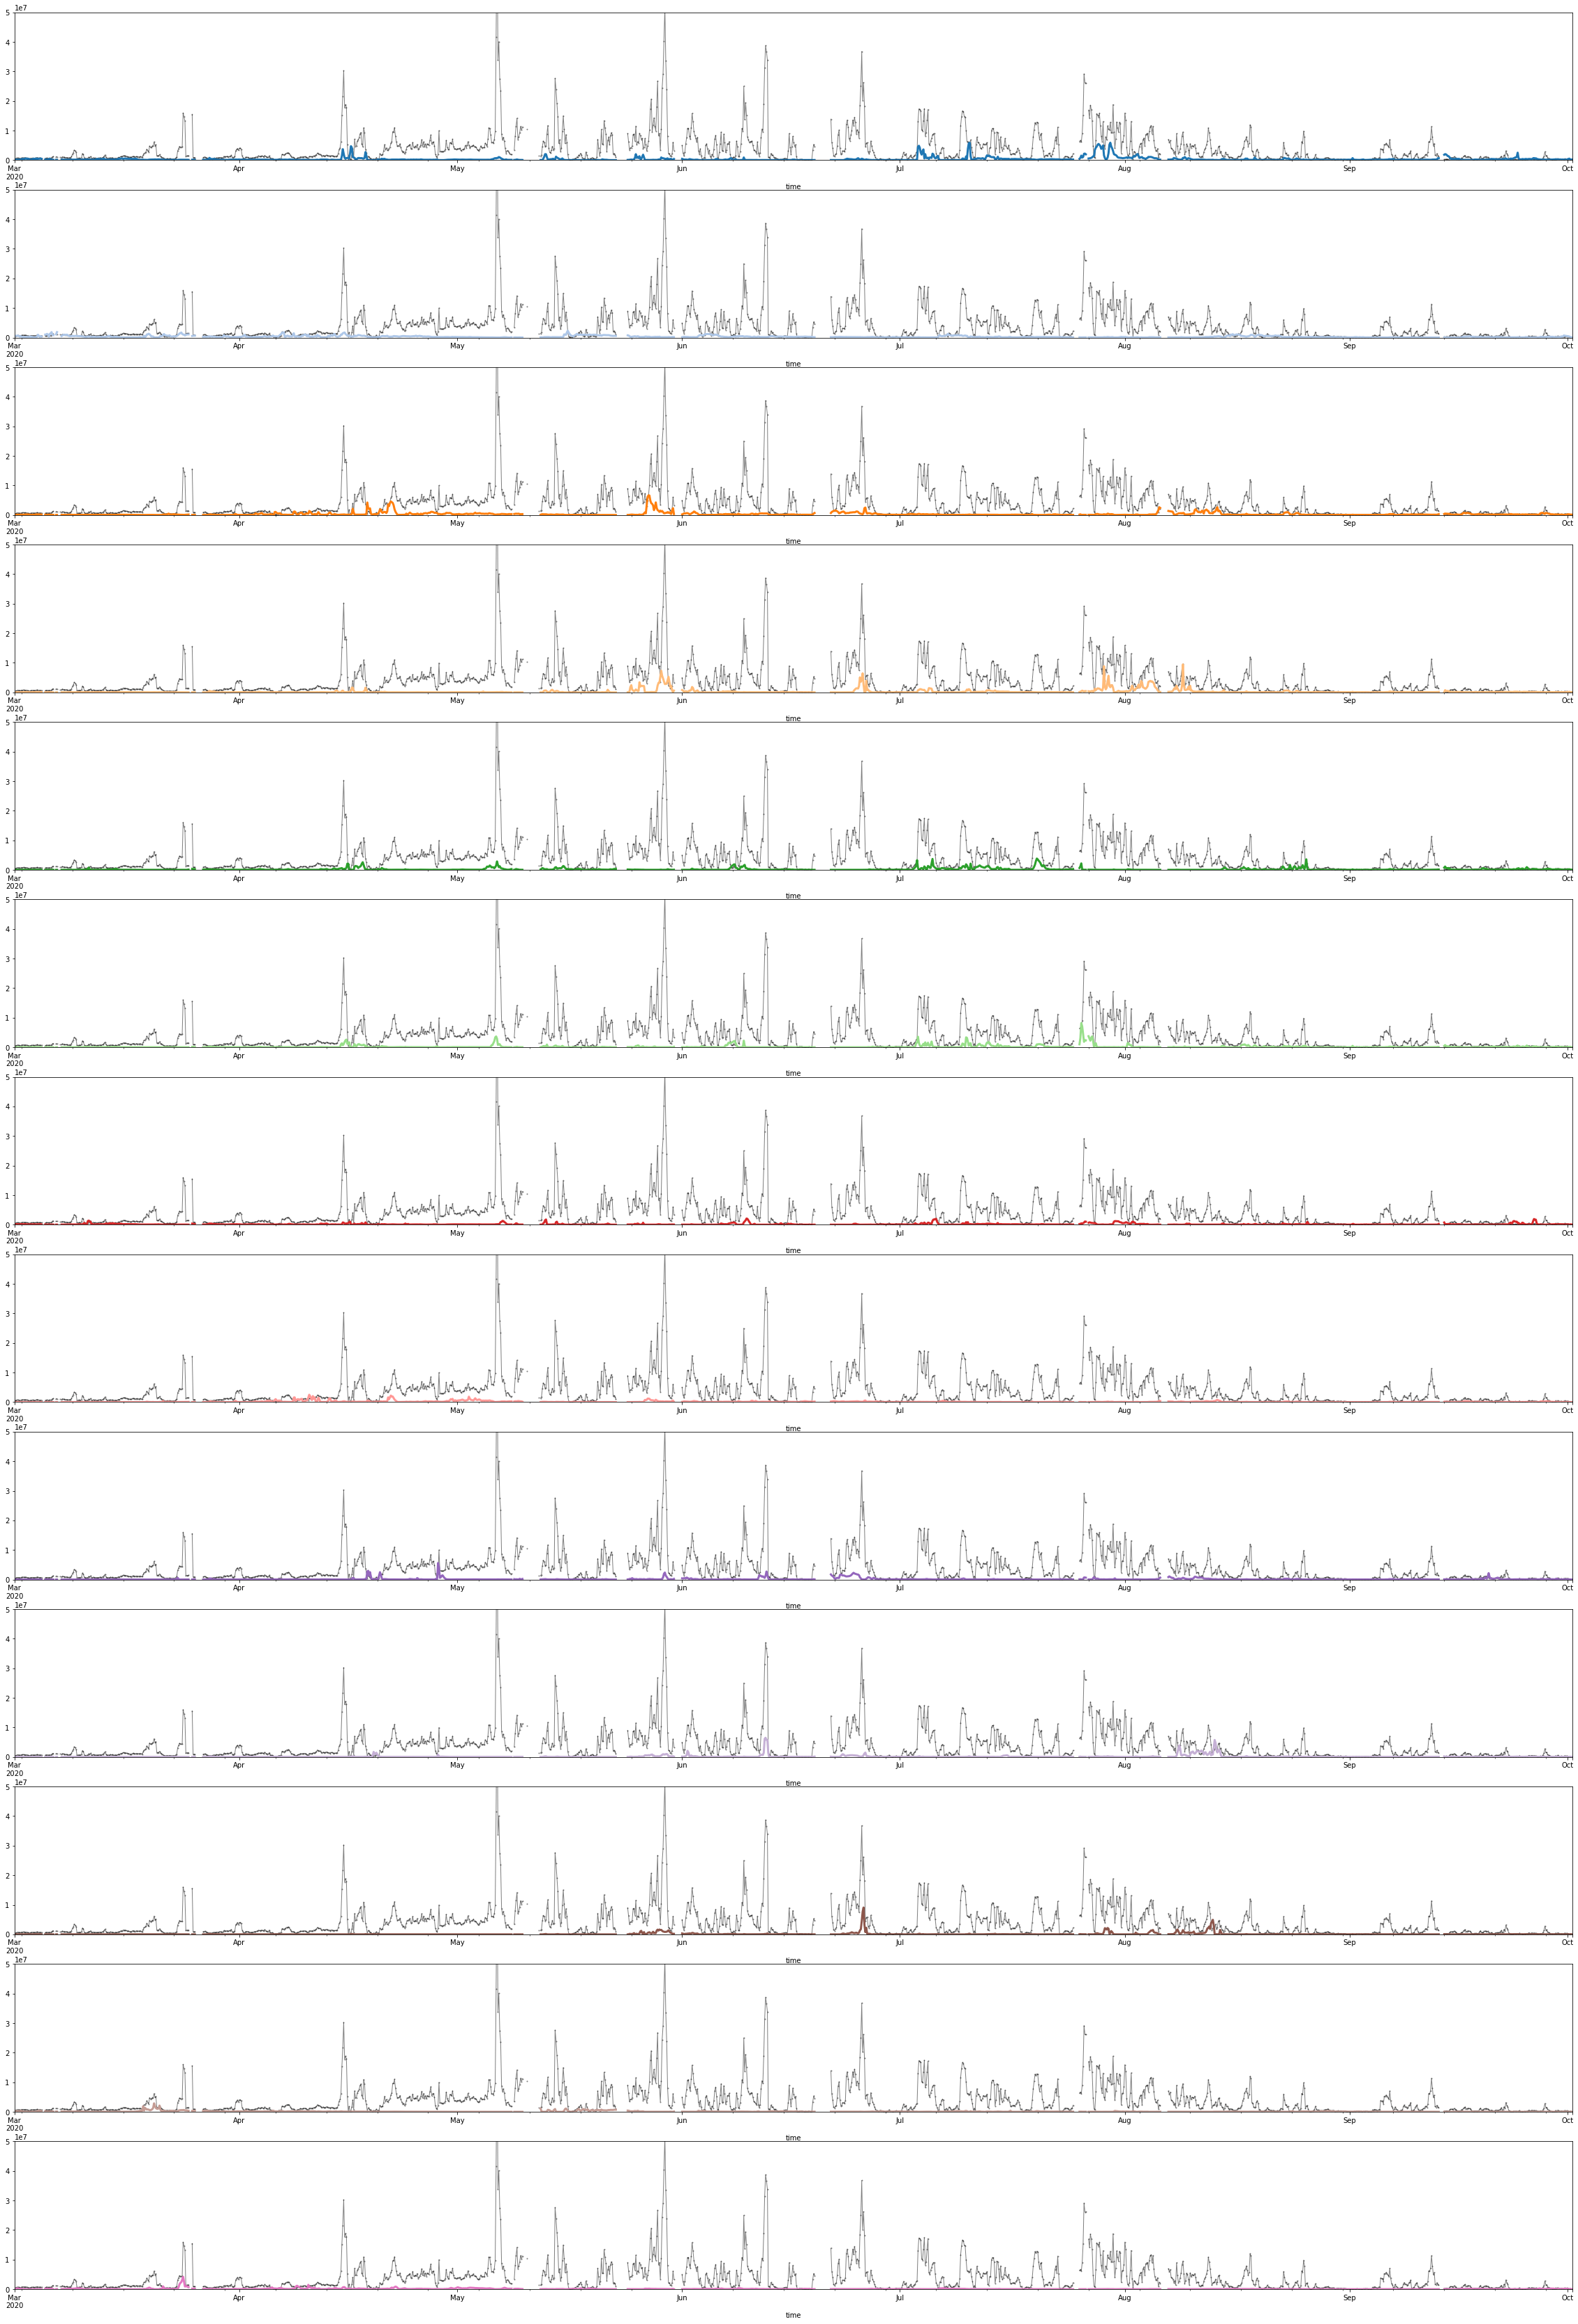

In [25]:
def plot_single_contrs(contrs, nl, yn, y, N):
    clus_ts = contrs.T.groupby(nl).sum().T[yn].resample("3H").mean()
    f, axs = plt.subplots(N, 1, figsize=(40, 3 * 20), sharey=True)
    axf = axs.flatten()
    for i in range(1, N + 1):
        y[yn].resample("3H").mean().plot(
            lw=1,
            marker="o",
            label="measured",
            c="k",
            mfc="none",
            alpha=0.5,
            ax=axf[i - 1],
            ms=1,
        )
        clus_ts[i].plot(ax=axf[i - 1], c=plt.get_cmap("tab20")(i - 1), lw=3)
        axf[i - 1].set_ylim(0, 5e7)


plot_single_contrs(contrs, nl, yn, y, N)

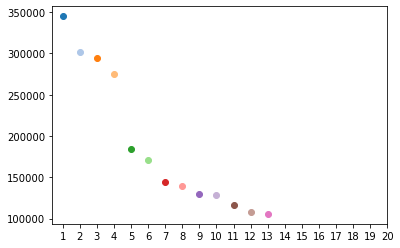

In [26]:
def plt_contrs(contrs, nl, N):
    d = contrs.T.groupby(nl).sum().T.mean()
    for i in range(0, N):
        plt.scatter(d.index[i], d.iloc[i], c=[plt.get_cmap("tab20")(i)])
    plt.gca().set_xticks(range(1, 21))


plt_contrs(contrs, nl, N)

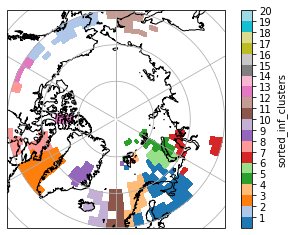

In [27]:
def _plt_influence_clusters(ds):
    import matplotlib as mpl

    _, ax = plt.subplots(subplot_kw=dict(projection=ccrs.Orthographic(0, 90)))
    ax.coastlines()
    ax.gridlines()
    (ds["sorted_inf_clusters"] - 0.5).plot(
        ax=ax,
        transform=ccrs.PlateCarree(),
        cmap="tab20",
        cbar_kwargs={"ticks": range(1, 21)},
        vmin=0,
        vmax=20,
    )


_plt_influence_clusters(ds)

# multi elastic net

In [70]:
ass = []
lss = [0.1, 0.5, 0.9, 0.99, 0.9999, 1]
for l_ in lss:
    pred, cdf, y, yn, dp, regr = rfu.elastic_net_reg2(dsf, dm, PAR, l1=[l_])
    ass.append(regr.alpha_)

661.0158816276198 0.1
132.2031763255241 0.5
73.44620906973559 0.9
66.76928097248688 0.99
66.10819898266031 0.9999
8738.240937131011 1


In [71]:
ass

[661.0158816276198,
 132.2031763255241,
 73.44620906973559,
 66.76928097248688,
 66.10819898266031,
 8738.240937131011]

In [79]:
aa = [1 / 8, 1 / 4, 1 / 2, 1, 2, 4]
CC = 28

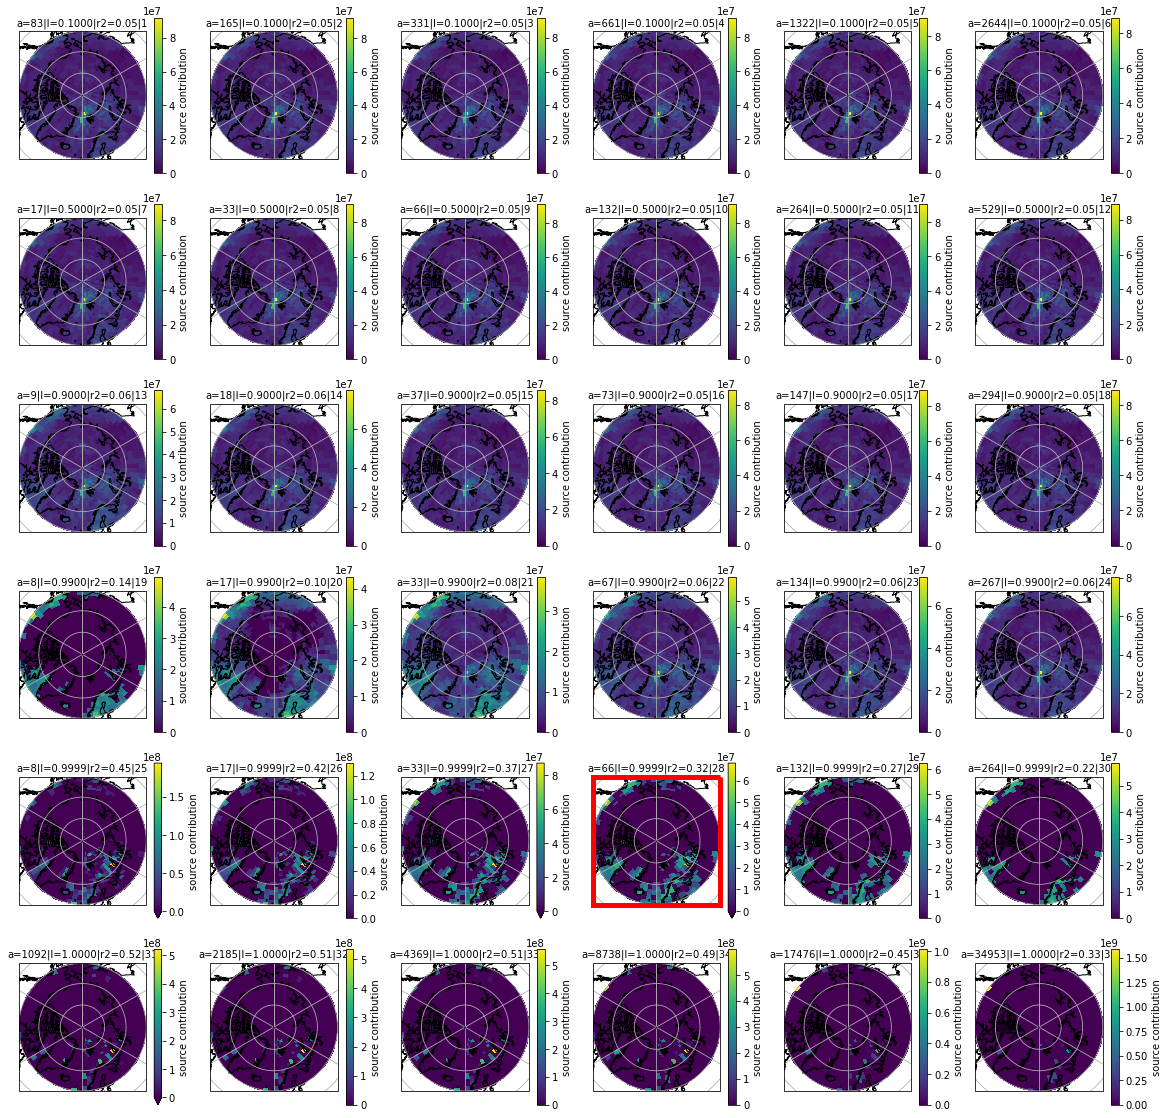

In [84]:
def elastic_net_reg3(dsf, dm, PAR, a, l):
    from sklearn.linear_model import ElasticNet

    c200 = dsf.columns

    X = dm[c200]

    ### normalize X
    xn = np.sqrt((X**2).sum()) ** (1 / 1)
    XX = X.divide(xn, axis=1)
    #############

    _y = dm[PAR]
    yn = _y.notna()
    y = _y[yn]
    regr = ElasticNet(
        a, l1_ratio=l, random_state=123, positive=True, fit_intercept=False
    )

    regr.fit(XX[yn], y[yn])

    #     print(regr.alpha_,regr.l1_ratio_)

    pred = regr.predict(XX[yn])
    dp = pd.Series(pred, index=y[yn].index)
    _cdf = pd.Series(regr.coef_, index=XX.columns)
    cdf = _cdf / xn
    return pred, cdf, y, yn, dp, regr


def _multi_plot(aa, CC):

    f, axs = plt.subplots(
        6, 6, figsize=(20, 20), subplot_kw=dict(projection=ccrs.Orthographic(0, 90))
    )
    #     axf = axs.flatten()

    i_ = 0
    pars = []
    for ii_ in range(6):
        for j_ in range(6):
            i_ = i_ + 1
            ax = axs[ii_, j_]
            l1_ = lss[ii_]
            a_ = ass[ii_] * aa[j_]
            pred, cdf, y, yn, dp, regr = elastic_net_reg3(dsf, dm, PAR, a_, l1_)
            r2, rat, inte = get_rat(dp, y, yn)
            contr = get_contr(rat, dm, dsf, cdf, 1, yn, inte)
            _plt(ds, contr, ax)
            ax.set_title(f"a={a_:.0f}|l={l1_:0.4f}|r2={r2:.2f}|{i_}", size=10)
            pars.append([a_, l1_])
            if i_ == CC:
                for spine in ax.spines.values():
                    spine.set_edgecolor("red")
                    spine.set_linewidth(5)
    return pars


pars = _multi_plot(aa, CC)

# chosen elastic net

In [87]:
pred, cdf, y, yn, dp, regr = elastic_net_reg3(dsf, dm, PAR, pars[CC][0], pars[CC][1])
r2, rat, inte = get_rat(dp, y, yn)

In [88]:
pars[CC][0], pars[CC][1]

(132.21639796532062, 0.9999)

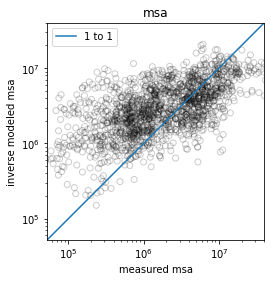

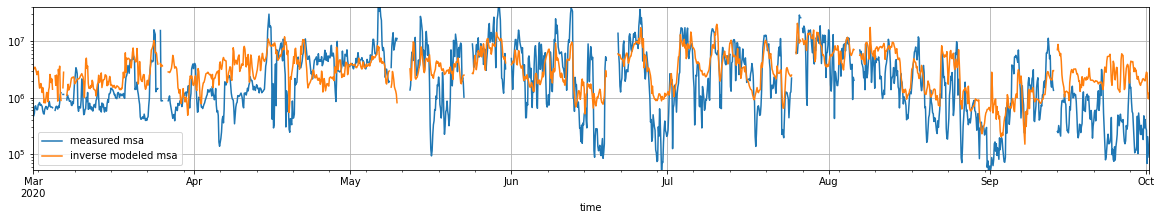

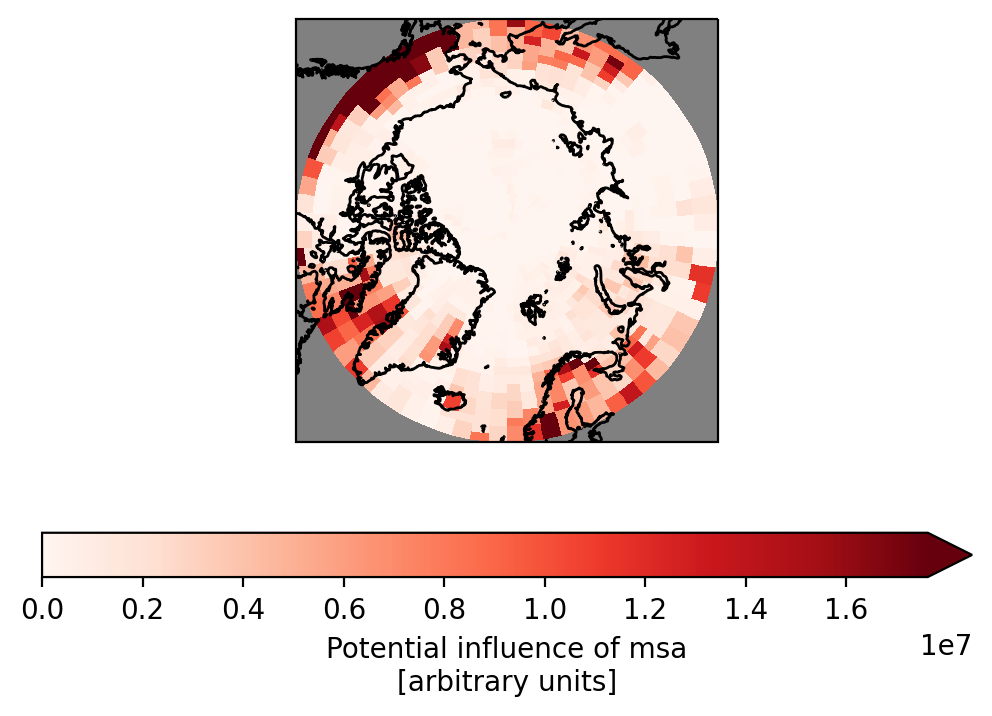

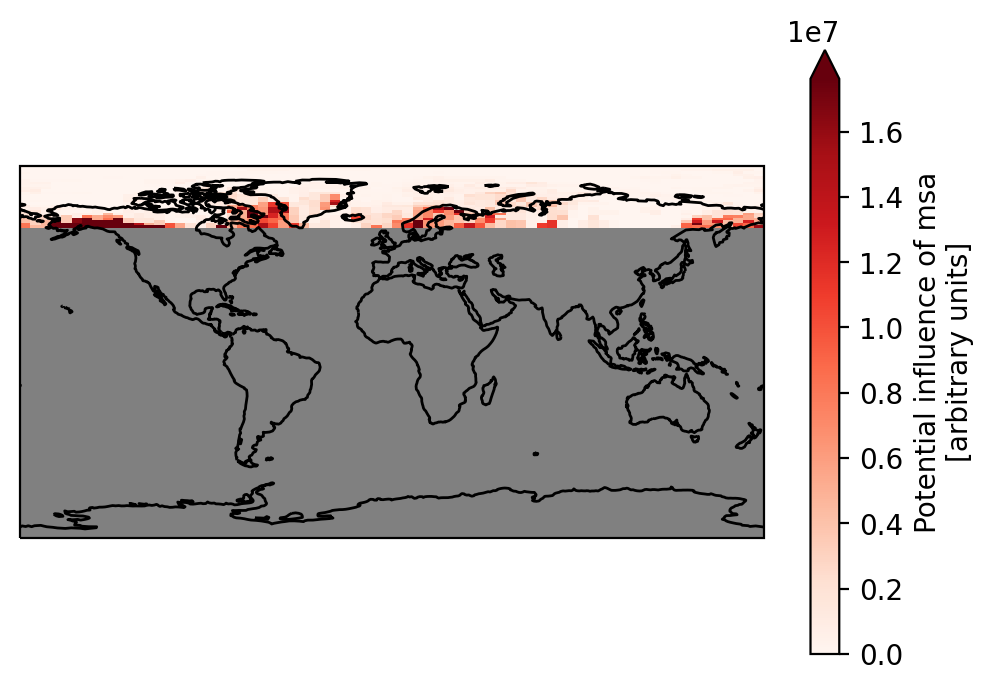

In [89]:
# for PAR in [SA,MSA,IA]:
def plt_el_net():

    MEA = f"measured {PAR}"
    MOD = f"inverse modeled {PAR}"
    rfu.scatter_plot(y, yn, pred * rat + inte, MEA, MOD, PAR)
    rfu.mea_vs_mod_plot(y, yn, dp * rat + inte, pred * rat + inte, MEA, MOD)
    # rfu.rank_cluster_inf(cdf)
    dd2 = rfu.get_plot_inf(cdf, L, ds, PAR)
    rfu.plot_map(dd2)
    rfu.plot_map_rect(dd2)
    return regr


regr = plt_el_net()

In [90]:
N = 20
contr = get_contr(rat, dm, dsf, cdf, 1, yn, inte)

(ds["sorted_inf_clusters"], contrs, nl) = _clus(
    dm, dsf, cdf, contr, ds, yn, rat, inte, N
)

/var/folders/xl/wx70j1c50bsdzdy63_wpbhrxpglmw2/T/ipykernel_47445/2105437306.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  clus_ts = contrs.T.groupby(nl).sum().T[yn].resample('3H').mean()


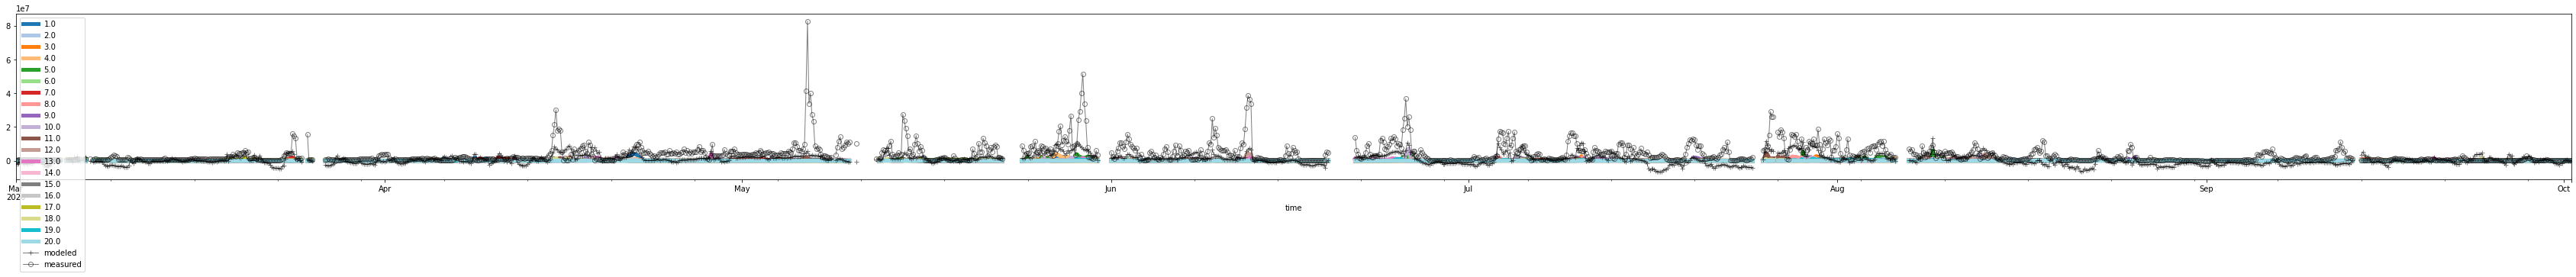

In [91]:
_plot_clust_infs(
    contrs=contrs, nl=nl, dsf=dsf, cdf=cdf, y=y, rat=rat, dm=dm, inte=inte, yn=yn, N=N
)

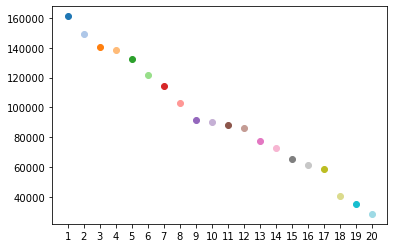

In [92]:
def plt_contrs(contrs, nl):
    d = contrs.T.groupby(nl).sum().T.mean()
    for i in range(0, 20):
        plt.scatter(d.index[i], d.iloc[i], c=[plt.get_cmap("tab20")(i)])
    plt.gca().set_xticks(range(1, 21))


plt_contrs(contrs, nl)

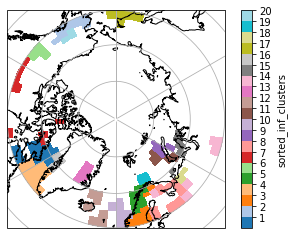

In [93]:
_plt_influence_clusters(ds)

/var/folders/xl/wx70j1c50bsdzdy63_wpbhrxpglmw2/T/ipykernel_47445/1956761208.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  clus_ts = contrs.T.groupby(nl).sum().T[yn].resample('3H').mean()


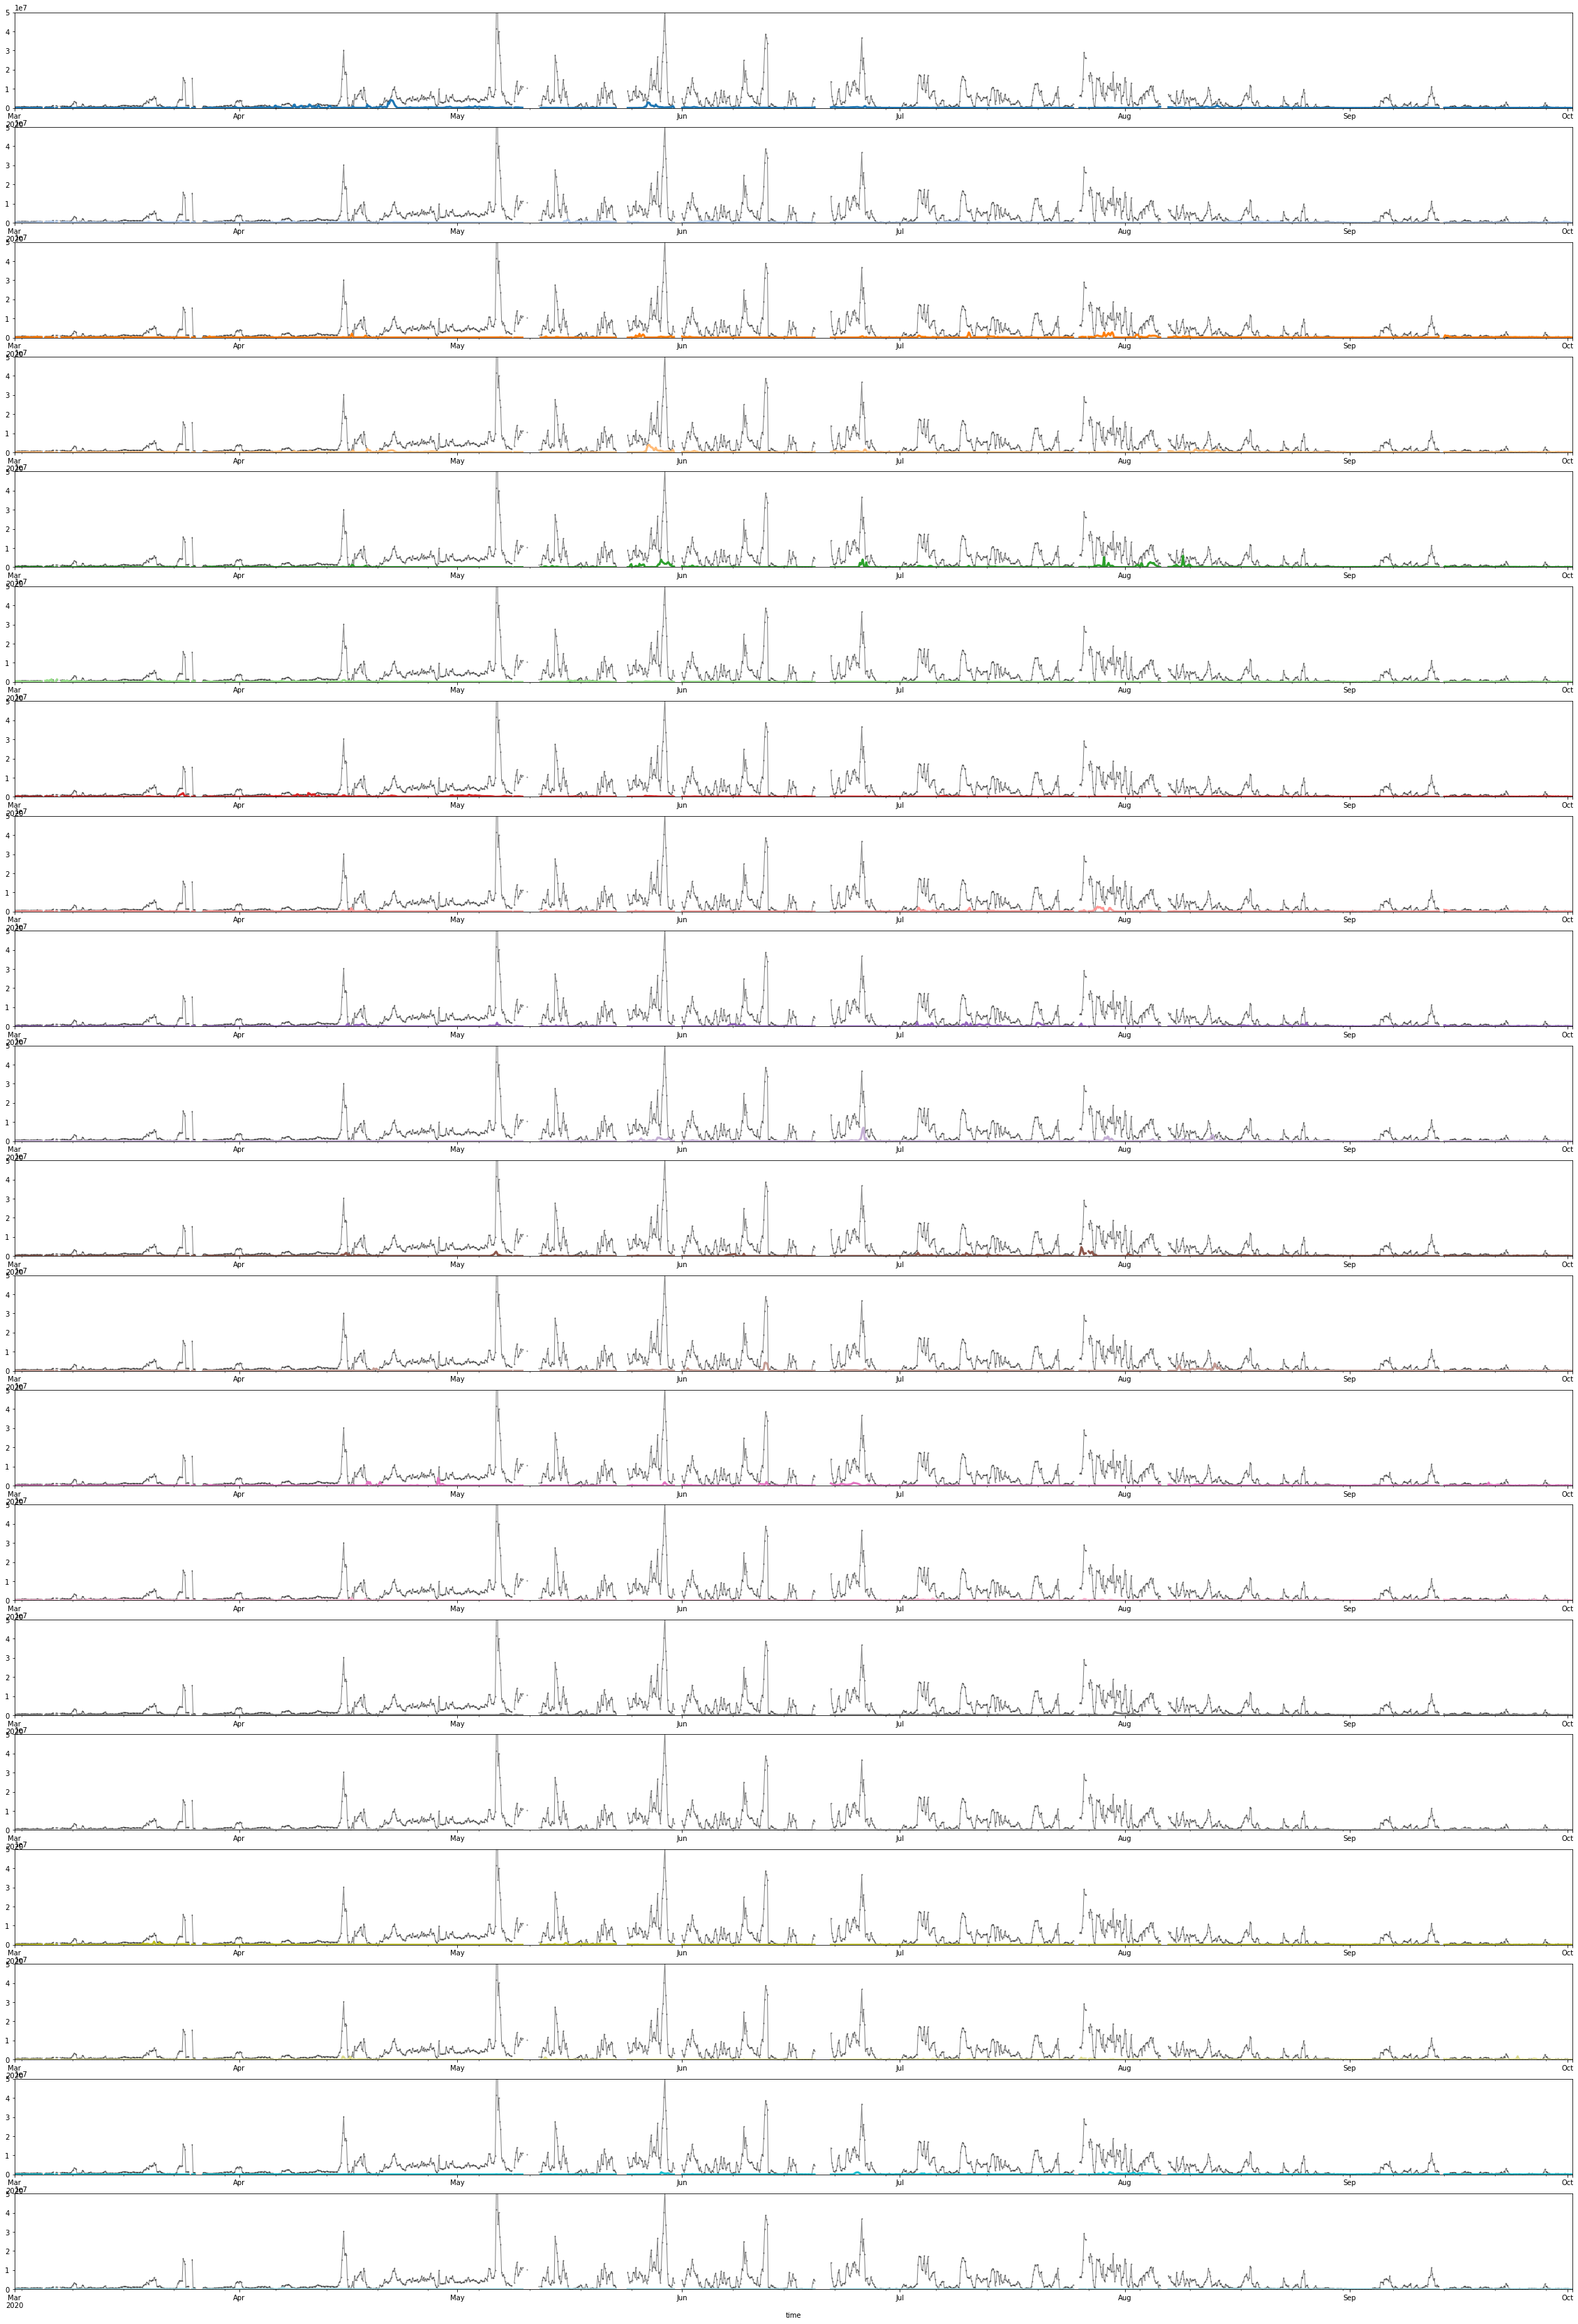

In [103]:
plot_single_contrs(contrs, nl, yn, y, N)
f = plt.gcf()

In [109]:
import matplotlib

In [120]:
# maybe easier to see with as symlog scale

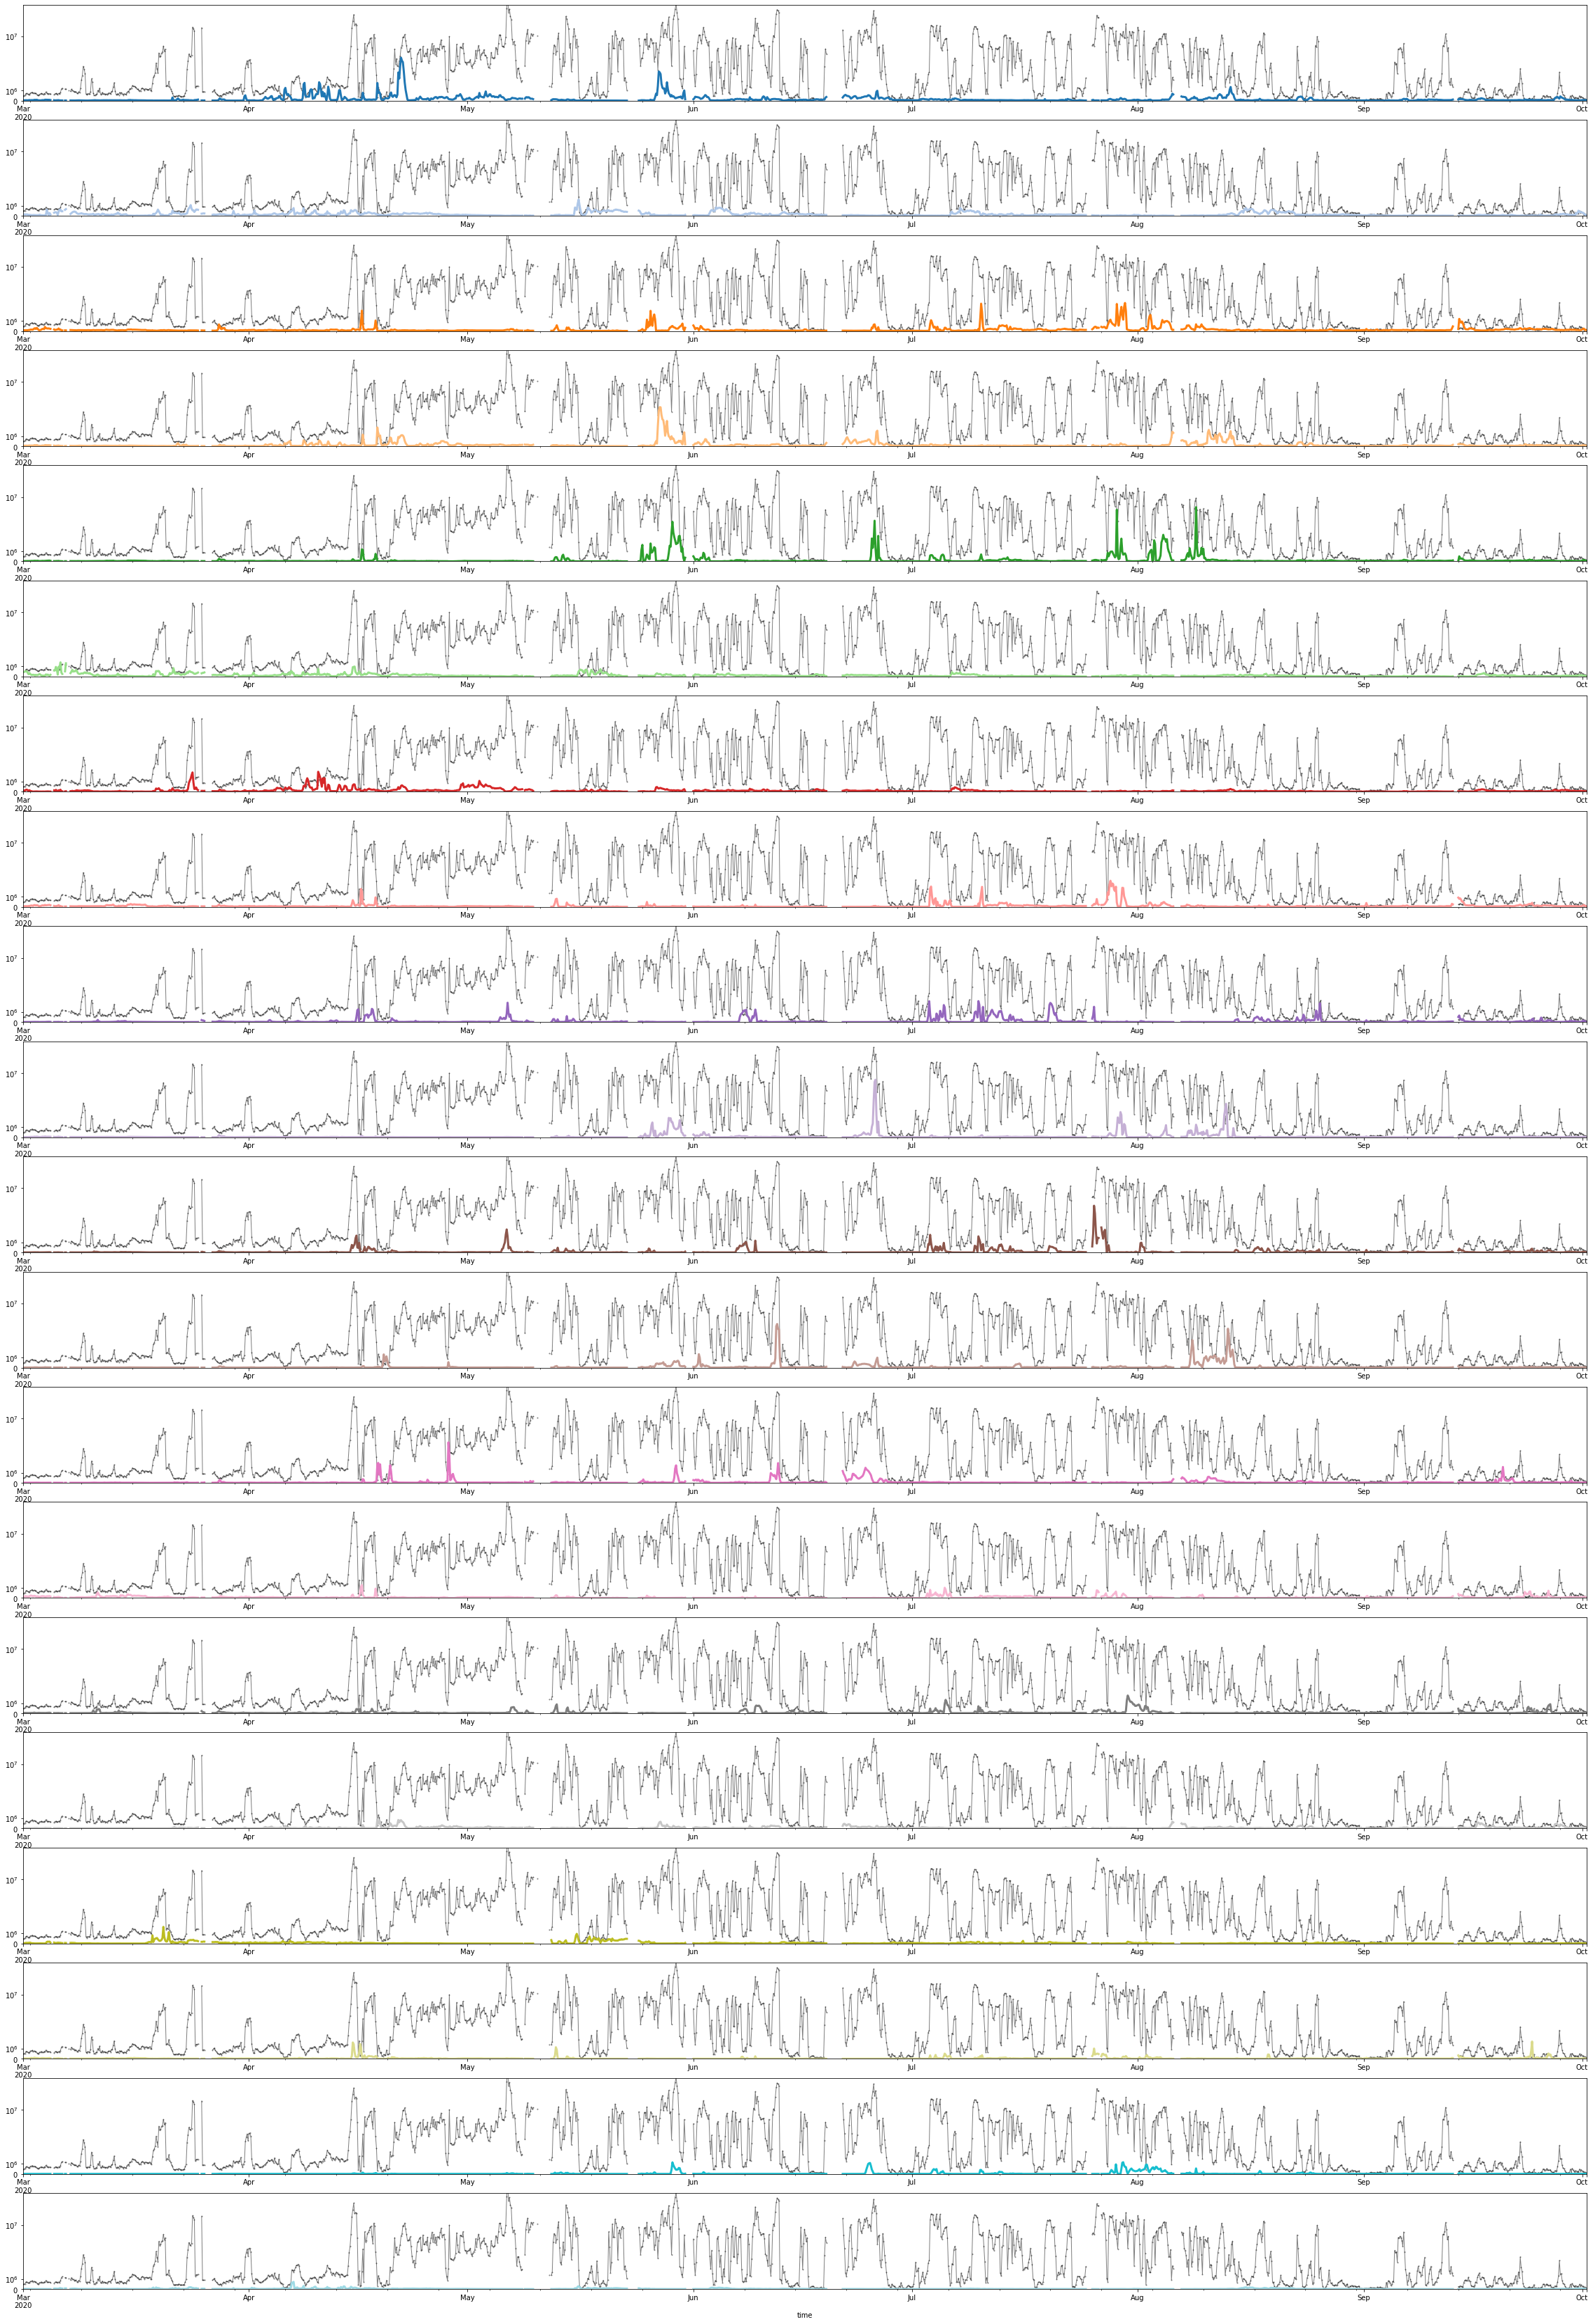

In [121]:
for ax in f.axes:
    ax.set_yscale("symlog", linthresh=5000000)
f

# save data

In [95]:
clus_ts = contrs.T.groupby(nl).sum().T[yn].resample("3H").mean()

/var/folders/xl/wx70j1c50bsdzdy63_wpbhrxpglmw2/T/ipykernel_47445/2478368837.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  clus_ts = contrs.T.groupby(nl).sum().T[yn].resample('3H').mean()


In [96]:
clus_ts

1.0            2.0            3.0           4.0   \
time                                                                            
2020-03-01 00:00:00  36501.332031  148877.484375   83869.968750  44698.773438   
2020-03-01 03:00:00  39592.296875  148058.265625   80058.062500  50830.796875   
2020-03-01 06:00:00  31130.378906  125195.859375   66479.328125  41310.398438   
2020-03-01 09:00:00  40742.210938  130496.859375   69626.390625  54095.574219   
2020-03-01 12:00:00  38028.988281  139311.750000   66153.203125  46291.988281   
...                           ...            ...            ...           ...   
2020-10-01 03:00:00  59764.148438  289478.562500  208383.453125  96354.710938   
2020-10-01 06:00:00  63513.894531  221896.890625  228832.718750  98755.601562   
2020-10-01 09:00:00  41324.750000  110731.968750  110500.710938  68608.851562   
2020-10-01 12:00:00  42323.968750   87405.906250   90498.242188  64114.195312   
2020-10-01 15:00:00  46357.996094   76659.492188  115821.585938  72609.867188   

                              5.0            6.0            7.0   \
time                                                               
2020-03-01 00:00:00   24087.402344  459612.531250   85717.937500   
2020-03-01 03:00:00   24310.578125  456947.687500  126014.093750   
2020-03-01 06:00:00   25793.011719  502342.125000  114947.101562   
2020-03-01 09:00:00   23159.515625  531745.437500  189251.515625   
2020-03-01 12:00:00   23678.208984  519157.156250  205617.609375   
...                            ...            ...            ...   
2020-10-01 03:00:00  123217.921875  115997.023438   59920.234375   
2020-10-01 06:00:00  143669.593750   92469.367188   53324.562500   
2020-10-01 09:00:00   49530.539062   63998.148438   35019.863281   
2020-10-01 12:00:00   42412.261719   54595.750000   36068.277344   
2020-10-01 15:00:00   69905.453125   52885.109375   38183.066406   

                              8.0            9.0           10.0          11.0  \
time                                                                            
2020-03-01 00:00:00   73606.515625    8272.626953  18772.660156   9333.255859   
2020-03-01 03:00:00   73708.125000    7269.271973  17202.507812   8522.770508   
2020-03-01 06:00:00   77069.585938    7005.641602  13337.608398   7913.102051   
2020-03-01 09:00:00   75290.039062    6358.460938  14925.310547   8098.388184   
2020-03-01 12:00:00   71993.796875    6511.737305  14642.927734   7267.347656   
...                            ...            ...           ...           ...   
2020-10-01 03:00:00  148968.000000  131542.812500  41580.394531  70783.476562   
2020-10-01 06:00:00  185325.375000  132765.218750  48087.132812  79383.648438   
2020-10-01 09:00:00   76991.453125   34118.578125  26811.236328  27431.365234   
2020-10-01 12:00:00   66677.429688   24033.650391  25199.751953  21700.080078   
2020-10-01 15:00:00   91813.359375   42751.718750  30617.294922  34817.585938   

                             12.0          13.0           14.0          15.0  \
time                                                                           
2020-03-01 00:00:00   9931.429688   8995.316406  122618.546875  31689.455078   
2020-03-01 03:00:00  11119.920898  11098.097656  132178.234375  26081.919922   
2020-03-01 06:00:00   7455.109375  10329.647461  183375.781250  25952.054688   
2020-03-01 09:00:00   9807.485352   9853.004883  169930.875000  23354.785156   
2020-03-01 12:00:00   8577.458008   8949.292969  147614.968750  23291.335938   
...                           ...           ...            ...           ...   
2020-10-01 03:00:00  38109.597656  34931.085938   89987.898438  46901.484375   
2020-10-01 06:00:00  40396.726562  36064.589844  115569.078125  40109.871094   
2020-10-01 09:00:00  22998.148438  20156.572266   81381.625000  20498.544922   
2020-10-01 12:00:00  22602.769531  16829.453125   70916.585938  18093.179688   
2020-10-01 15:00:00  28287.394531  21433.142578   75536.898438  23936.173828

In [97]:
clus_ts.to_csv(OUT_FILE)

In [98]:
fu.compressed_netcdf_save(ds, OUT_DS_FILE)

In [99]:
contrs.to_csv(OUT_CONTRS_FILE)

In [100]:
yn.to_csv(OUT_MEAS_FILE)